# TomoTwin: A simple digital twin for synchrotron micro-CT

### Author: Aniket Tekawade  

1. Phantom with a void (Label 0 is void, label 1 is material)  
2. model attenuation / noise with Poisson assumption and data from XOP  
3. model phase-contrast with inverse phase-retrieval step (assuming refractive index is proportional to absorption coefficient  
4. model beam profile without flat-field  


Important Information: Data from this notebook has not been published yet. Please contact the author if you intend on using it.  



In [1]:
%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
import time

# local imports
if "../tomo_twin" not in sys.path: # local imports
    sys.path.append('../tomo_twin')
import ray_utils as ray
from utils import *
material_data_path = '/data02/MyArchive/TomoTwin/model_data'

# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display
figw = 12

In [2]:
sample_tag = "block_sample_01"

### Select the FOV  

In [3]:
FOV = (800,1920) # Vertical, Horizontal in nrows, ncols
res = 1.172
n_projections = 2001
print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))

FOV of 0.9 mm high, 2.3 mm wide; pixel size 1.17 um
Shape of the projection image: (800, 1920)


### Select the acquisition parameters: (beam energy, # projections,)  

In [4]:
energy_pts = 52.0 # can also input a discrete list of energies, e.g. np.asarray([7,14,28]), etc.
theta = (0,180,n_projections)
noise = 1.0 # the noise std. dev. based on the Poisson model is increased by that factor.  
blur_size = 3 # blur kernel
detector_dist = 30.0 # cm

In [5]:
beam = (2**16-2000)*np.ones(proj_shape, dtype = np.float32)[np.newaxis,...]
print("beam array shape is n_energies, nz, nx: %s"%str(beam.shape))

beam array shape is n_energies, nz, nx: (1, 800, 1920)


intensity range in projection image: 63536 to 63536


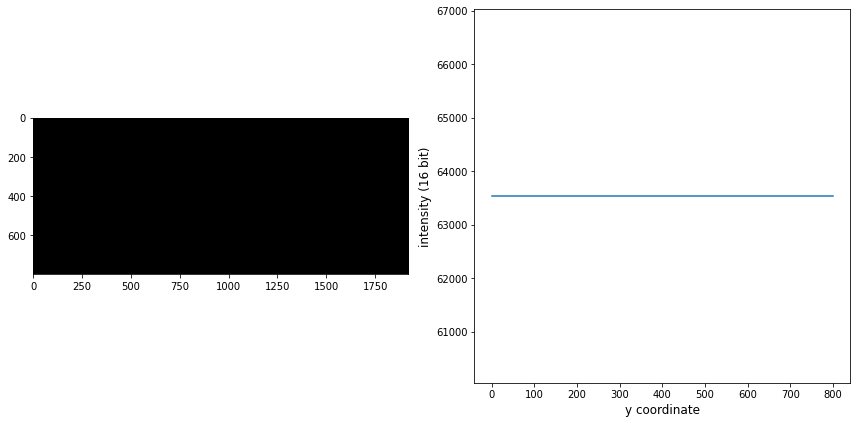

In [6]:
print("intensity range in projection image: %i to %i"%(beam.min(), beam.max()))
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(beam[0], cmap = 'gray')
h = ax[1].plot(beam[0,:,beam.shape[-1]//2])
h = ax[1].set_xlabel("y coordinate", fontsize = 12)
h = ax[1].set_ylabel("intensity (16 bit)", fontsize = 12)
fig.tight_layout()

Nothing fancy being done with the beam profile.  

## Make the Ground-Truth Phantom: through-hole   


### 1. Define the phantom parameters  

In [7]:
mat_dict = {"air" : 0.00122, "Al" : 2.7}

phantom_params = {"hole_dia" : 380, \
                  "hole_y" : 400, \
                  "hole_x" : 960}

In [8]:
obj_shape

(800, 1920, 1920)

In [9]:
def make_through_hole(obj_shape, hole_dia = 380, hole_y = 400, hole_x = 960):
    img = np.ones(obj_shape[:2], dtype = np.uint8)
    yr = np.arange(-hole_y, -hole_y+obj_shape[0])
    xr = np.arange(-hole_x, -hole_x+obj_shape[1])
    
    yy, xx = np.meshgrid(yr, xr, indexing = 'ij')
    dist = np.sqrt(yy**2 + xx**2)
    
    mask = np.ones(obj_shape, dtype = np.uint8)
    mask[dist < hole_dia//2,:] = 0 
    
    return mask    

In [10]:
vol = make_through_hole(obj_shape, *phantom_params)

In [11]:
vol.shape

(800, 1920, 1920)

In [12]:
# make_voids_inclusions is defined in the utils.py file  
t0 = time.time()
tot_time = (time.time() - t0)/60.0
print("Done in %.2f minutes"%tot_time)

Done in 0.00 minutes


In [13]:
Ph = ray.Phantom(vol, mat_dict, res, energy_pts, data_path = material_data_path)

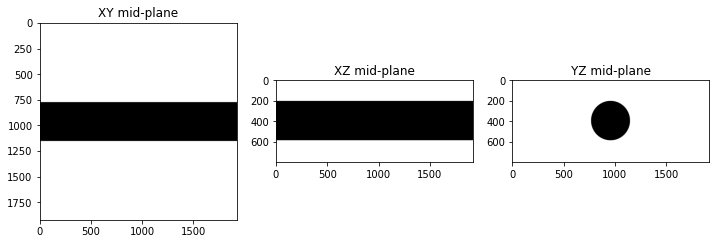

In [18]:
fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = Ph.vol, ax = ax)

### 2. How does the resulting tomo volume look like?  

In [19]:
voxel_values = np.unique(Ph.vol[::2,::2,::2])
voxel_values = {}

for ii in range(len(mat_dict)):
    vox_entry = np.mean(Ph.vol[vol == ii])
    voxel_values.update({ii : vox_entry})
print("The ground-truth phantom has labels %s, void, material and inclusions respectively.\n\
After applying the attentuation / density properties, the corresponding voxel values are:\
\n\n\t\t%s"%(np.unique(vol[::2,::2,::2]), voxel_values))

The ground-truth phantom has labels [0 1], void, material and inclusions respectively.
After applying the attentuation / density properties, the corresponding voxel values are:

		{0: 2.9002392e-08, 1: 0.00010902908}


## Synthetize Projections  

In [20]:
t0 = time.time()
projs = Ph.get_projections(theta = theta, beam = beam, \
                           noise = noise, \
                           detector_dist = detector_dist, \
                           blur_size = blur_size)
tot_time = (time.time() - t0)/60.0
print("Shape of the synthesized projections data: %s"%str(projs.shape))
print("Done in %.2f minutes"%tot_time)

Shape of the synthesized projections data: (2001, 800, 1920)
Done in 88.17 minutes


### View Projections  

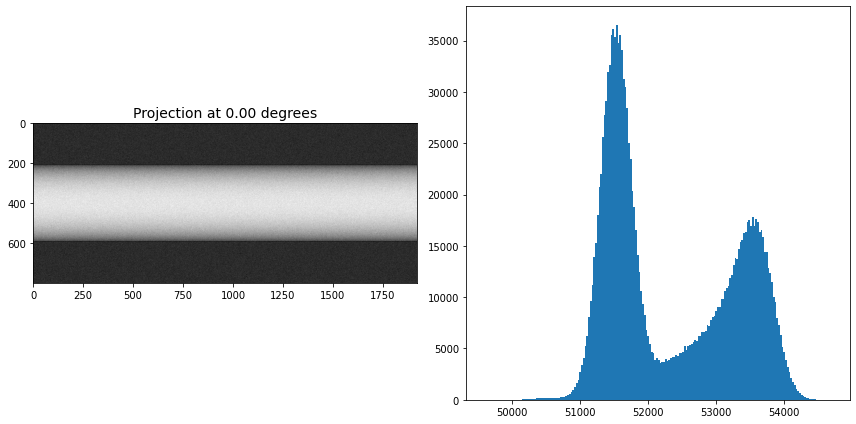

In [21]:
img_show = projs[0].copy()
img_show = np.clip(img_show, *modified_autocontrast(img_show, s = 0.01))
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(img_show, cmap = 'gray')
h = ax[0].set_title("Projection at %.2f degrees"%theta[0], fontsize = 14)
h = ax[1].hist(projs[0].reshape(-1), bins = 200)
# h = ax[1].imshow(projs[-1], cmap = 'gray')
# h = ax[1].set_title("Projection at %.2f degrees"%theta[1], fontsize = 14)
fig.tight_layout()

### View Sinograms  

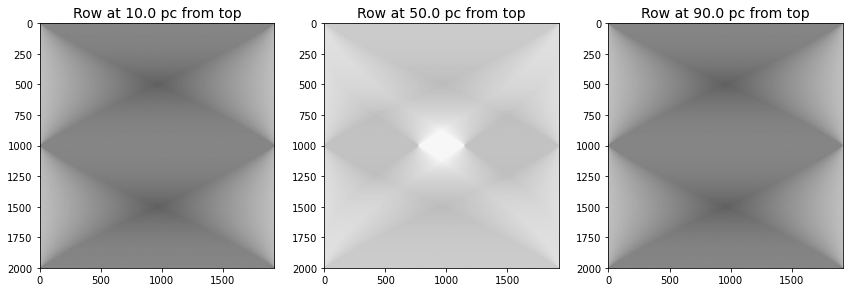

In [22]:
select_rows = [0.1,0.5,0.9]
select_idx = [int(select_row*projs.shape[1]) for select_row in select_rows]
fig, ax = plt.subplots(1,len(select_rows), figsize = (figw,figw/len(select_rows)))
for ii, idx in enumerate(select_idx):
    ax[ii].imshow(projs[:,idx,:], cmap = 'gray')
    ax[ii].set_title("Row at %.1f pc from top"%(100.0*select_rows[ii]), fontsize = 14)
fig.tight_layout()

## Do a test reconstruction with gridrec  

In [23]:
mask_ratio = 0.95
contrast_s = 0.01
rec = recon_wrapper(projs, beam, theta, pad_frac = 0.8, mask_ratio = mask_ratio, contrast_s = contrast_s)

Reconstructing 48 slice groups with 48 master threads...


ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (figw, figw/3))
h = viewer.view_midplanes(rec, ax = ax)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
idx_mid = int(rec.shape[0]//2)
viewer.edge_plot(rec[idx_mid], vol[idx_mid], ax = ax, color = [255,0,0])
ax.set_title("SNR = %.2f"%calc_SNR(rec[idx_mid], vol[idx_mid], labels = (0,1), mask_ratio = mask_ratio))

In [ ]:
SNR_voids = calc_SNR(rec, vol, labels = (0,1), mask_ratio = mask_ratio)
print("SNR of material against voids: %.2f"%SNR_voids)

**Comments:** In this example, that there are two signal-noise ratios (SNR) to be evaluated: the contrast between the material and voids in background and the contrast between the inclusions against the material background. Depending on the attenuation properties of the materials, these may be very different.  

## Save Data Pairs  

We will save the following:  
1. Ground-truth labeled phantom (nz, ny, nx): Label 0 is void, label 1 is material, label 2 is inclusion material.  
2. Projection data: 16 bit data (n_projections, nrows, ncolumns).  
Note that ny = nx = ncolumns and nrows = nz.  
3. Test reconstruction: float (nz, ny, nx)

In [25]:
import json
import os

In [26]:
fname = "%s.hdf5"%sample_tag
fpath = os.path.join("/data02/MyArchive/TomoTwin/data", fname)
hf = h5py.File(fpath, 'w')

In [27]:
# save exchange/data, exchange/data_bright and data_dark
g = hf.create_group("exchange")
d = g.create_dataset("data", data = projs, dtype = np.uint16)
d = g.create_dataset("data_bright", data = beam, dtype = np.uint16)
d = g.create_dataset("data_dark", data = np.zeros_like(beam), dtype = np.uint16)

In [28]:
# save exchange/measurement
gm = g.create_group("measurement")
gm.attrs["pixel_size"] = res
gm.attrs["energy"] = energy_pts
gm.attrs["detector_dist"] = detector_dist
gm.attrs["n_projections"] = n_projections
gm.attrs["noise_level"] = noise
gm.attrs["blur_kernel"] = blur_size

In [29]:
crop_slice, vcrop_slice = get_cropslices(vol.shape, mask_ratio)

# save phantom
g = hf.create_group("tomo")
d = g.create_dataset("gt_labels", \
                     data = vol[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
d = g.create_dataset("recon", \
                     data = rec[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
gm = g.create_group("phantom")
gm.attrs["sample_tag"] = sample_tag
m = gm.create_dataset("mat_dict", data = json.dumps(mat_dict))
m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))

In [30]:
hf.close()

In [31]:
time.ctime()

'Mon Jan 25 12:20:43 2021'

In [20]:
# hf = h5py.File("../data/data01.hdf5", 'w')
# hf.create_dataset("gt_labels", data = vol)
# hf.create_dataset("projs", data = projs)
# hf.create_dataset("test_rec", data = rec)

## Explanation of the Noise Model  

Excellent reference article here:  
https://web.eecs.umich.edu/~fessler/course/516/l/c6-noise.pdf  

Let's say the initial number of photons originating from the beam through a single pixel is $N_0$, and the final number of photons (deterministically) surviving and landing on the scintillator is represented as follows. This is exactly what we have implemented in the code so far.  

<font size = 3><center>$N_0 exp({\sum_i-{\sigma_i}{r_s}y_i})$</center></font>

${r_s}$ is the resolution (microns/pixel), ${\sigma_i}$ is the attenuation coefficient based on the elemental composition and the mass density.  

Now the twist is to convert this into a probabilistic model to simulate noise. The article says that we can model the exponent (attenuation factor) as a survival probability. Hence, if $N_0$ photons are entering the material, the "expected" number of photons $M$ that survive are given by a probability distribution that is Poisson. Here, $\lambda$ is the parameter for a Poisson distribution.  


<font size = 3><center>$E[M] = {N_0}*exp({\sum_i-{\sigma_i}{r_s}y_i})$ = $\lambda$</center></font>

Finally, we invoke the approximation that for large value of $\lambda$, the Poisson distribution tends to a normal distribution $N(\mu=\lambda,\sigma=\sqrt\lambda$). Hence, the projection image at a given theta is generated by first using tomopy.project to calculate $\lambda$ values for each pixel coordinate (Z,X). Then, $\hat{I}$ is the intensity sampled from this normal distribution. The Y coordinate is along the ray axis and $i$ is the pixel $i$ along the ray axis.  

<font size = 4><center>$\hat{I}(z,x) = N(\lambda, \sqrt\lambda)$ where $\lambda(z,x) = {{I_0(z,x)}*exp({\sum_i-{\sigma_i(z,x)}{r_s}y_i})}$</center></font>
    

In [23]:
mu = np.linspace(1,10,10000, endpoint=True)**2
sigma = np.geomspace(0.1,10,10000)

Text(0, 0.5, '$\\hat{I}$')

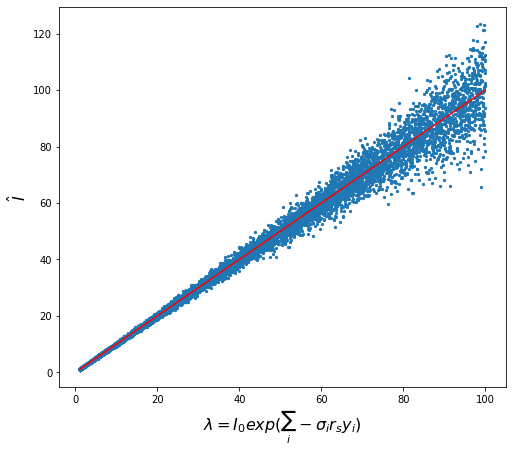

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
ax.plot(mu, mu, color = 'red')
ax.scatter(mu, np.random.normal(mu,sigma), s = 5)
ax.set_xlabel("$\lambda = {I_0}exp({\sum_i-{\sigma_i}{r_s}y_i})$", fontsize = 16)
ax.set_ylabel("$\hat{I}$", fontsize = 16)